### Figure 1 redshift distribution

In [ ]:
# just_show_distance(survey = 'first', show_uplim = 3, bin_size = 0.1)
# just_show_distance(survey = 'nvss', show_uplim = 25, bin_size = 0.5)
just_show_distance(survey = 'gleam', show_uplim = 110, bin_size = 5)
# just_show_distance(survey = 'racs', show_uplim = 14, bin_size = 0.5)

In [51]:
# Do with newly inspected table
vis_inp_table = '/Users/yingkangzhang/wps_workspace/wps_cloud/hi_z/inspected_catalog.csv'
table_vi = pd.read_csv(vis_inp_table, encoding='gbk')
table_vi['Sample']
tab_good = table_vi[(table_vi['Sample'].str.contains('cand B')) & (table_vi['match_tier_first'] >= 1)].reset_index(drop=True)
tab_good

,sdss_name,sdss_ra,sdss_dec,sdss_z,sdss_source_z,sdss_zwarning,z_reliable_flag,FIRST,match_tier_first,Fpeak_first,...,match_tier_mark,sep_first,sep_nvss,sep_racs,sep_gleam,resolve_gleam,sdss_name.1,Sample,Note1,Note2
0,144603.26+162955.7,221.513586,16.498826,3.054,VI,0,1,J144603.2+162955,1.0,2.71,...,NaN,0.339,10.626,13.903,NaN,NaN,144603.26+162955.7,cand B,nearby radio source affect 23,"2 affected, tar dom"
1,015536.40-010005.9,28.901668,-1.001645,3.352,VI,0,1,J015536.4-010006,1.0,1.72,...,b,0.257,19.046,13.311,NaN,NaN,015536.40-010005.9,cand B,2 affected by radio,2 mixed tar and radio
2,072855.92+251313.8,112.233033,25.220527,3.302,VI,0,1,J072855.9+251314,1.0,1.42,...,"b,c",0.316,11.080,13.074,NaN,NaN,072855.92+251313.8,cand B,RG? ext?,"2,3 affected by different source"
3,144640.02+475038.9,221.666767,47.844144,3.394,VI,0,1,J144639.9+475039,1.0,4.13,...,NaN,0.610,24.037,NaN,NaN,NaN,144640.02+475038.9,cand B,2 weak and extend,NaN
4,125834.36+235709.1,194.643178,23.952542,3.103,VI,0,1,J125834.3+235710,1.0,1.06,...,"b,c",1.207,14.822,12.290,NaN,NaN,125834.36+235709.1,cand B,23 dominated by mix,1 good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,011540.51+035643.3,18.918796,3.945378,4.189,VI,4,1,J011540.5+035643,1.0,100.84,...,"b,d",0.180,0.593,0.545,26.300,1.161,011540.51+035643.3,cand B,radio contaminate 4,radio affect 4
75,162324.71+154247.9,245.852970,15.713321,3.091,VI,0,1,J162324.7+154248,1.0,96.72,...,d,0.175,0.239,0.509,23.259,1.023,162324.71+154247.9,cand B,NaN,cp may dominate 4
76,134056.21+105827.4,205.234224,10.974284,3.182,VI,0,1,J134056.2+105827,1.0,44.80,...,d,0.438,0.773,0.424,31.207,1.818,134056.21+105827.4,cand B,radio affect 4,radio affect 4
77,083549.42+182520.0,128.955939,18.422248,4.412,VI,0,1,J083549.4+182520,1.0,51.49,...,d,0.131,0.853,0.342,17.033,1.153,083549.42+182520.0,cand B,NaN,cp affect 4


In [64]:
def just_show_distancev2(survey = 'first',
                        df_table = table_vi,
                        show_uplim = 3,
                        bin_size = 0.1,
    ):
    n_bins = int(show_uplim / bin_size)  # Number of bins based on

    df_good = df_table[df_table['Sample'].str.contains('good')].reset_index(drop=True)
    df_cand = df_table[(df_table['Sample'].str.contains('cand B')) | (df_table['Sample'].str.contains('cand C'))].reset_index(drop=True)

    data = df_good['sep_'+survey]
    data_t23 = df_cand['sep_'+survey]
    data=data.dropna(); data_t23 = data_t23.dropna()
    print(f"The number of data points: {len(data)}")
    print(f"The number of data points cand: {len(data_t23)}")

    plt.figure(figsize=(9, 6))
    plt.hist([data,data_t23], bins=n_bins, range=(0, show_uplim),
         stacked=True,
         linewidth=0.2,
         edgecolor='black',
         color=['steelblue', 'darkorange'],
         label=[f'Separation_{survey} (good)', f'Separation_{survey} (candidate)'])
    survey_name=survey.upper()
    plt.title(f'{survey_name}-SDSS', fontsize=20)
    plt.xlabel(f'Separation (arcsec)', fontsize=20)
    plt.ylabel('Number of Sources', fontsize=20)
    # using log scale for y-axis
    plt.xlim(0, show_uplim)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig(f"./figures/{survey_name}_SDSS.pdf", format='pdf', dpi=200)
    plt.show()

The number of data points: 91
The number of data points cand: 47


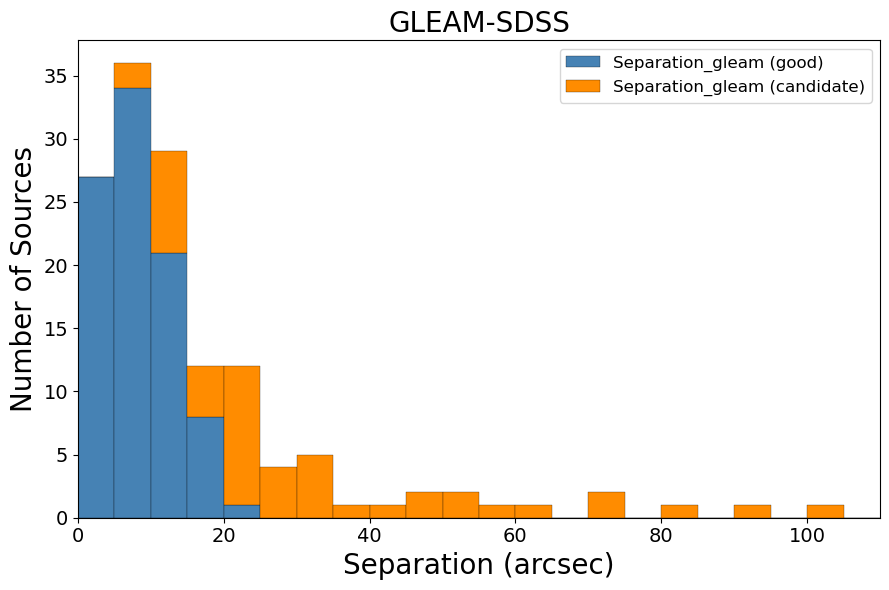

In [70]:
# just_show_distancev2(survey = 'first', show_uplim = 3, bin_size = 0.1)
# just_show_distancev2(survey = 'nvss', show_uplim = 25, bin_size = 0.5)
just_show_distancev2(survey = 'gleam', show_uplim = 110, bin_size = 5)
# just_show_distancev2(survey = 'racs', show_uplim = 14, bin_size = 0.5)

### Figure 6 data analysis

In [71]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.table import Table
# prepare data

final_table_path = 'final_matched_highz_catalogue.fits'
ref_table_patha = 'matched_radio_highz_catalogue.fits'
ref_table_pathb = 'ref_o1r1234_all_sources.fits'
with fits.open(final_table_path) as hdul:
    data = hdul[1].data
    table_fi = Table(data)
df_fi = table_fi.to_pandas()

with fits.open(ref_table_patha) as hdul:
    data = hdul[1].data
    table_fa = Table(data)
df_ref_a = table_fa.to_pandas()

# select subset with z_reliable_flag == 1 and match_tier_first exist and =1
# df_z12 = df_fi[df_fi['z_reliable_flag'] <= 2].reset_index(drop=True)
# This block can be used to various analysis
def get_tier_flag(row,column_use):
    tiers = row[[column_use]]
    if any(t == 1 for t in tiers):
        return 'tier_1'
    elif any(t in [2, 3] for t in tiers):
        return 'tier23'
    else:
        return 'none'  # 可选
def filter_df(df1,df_full,z_flag_lim = 1):
    # df1.replace([-32768,-2147483648], 'NA', inplace=True)
    df1=df1[df1['z_reliable_flag'] <= z_flag_lim].reset_index(drop=True)
    df_full=df_full[(df_full['sdss_name'].isin(df1['sdss_name'])) | (df_full['match_tier_first'] >= -1) \
                     | (df_full['match_tier_nvss'] >= -1) | (df_full['match_tier_gleam'] >= -1) | (df_full['match_tier_racs'] >= -1)
                    ].reset_index(drop=True)
    return df1,df_full

df_good,df_full_good= filter_df(df_fi, df_ref_a, z_flag_lim=1)
df_ref_a


,sdss_name,sdss_ra,sdss_dec,sdss_class,sdss_z,sdss_source_z,sdss_z_pipe,sdss_zwarning,sdss_z_vi,sdss_z_conf,...,e_amaj0_r4,e_bmin0_r4,e_PA0_r4,Separation_racs,GrpSize_before_racs,group_z_min_racs,group_z_max_racs,GroupID_racs,GroupSize_racs,match_tier_racs
0,102651.46+590628.0,156.714441,59.107796,QSO,3.407000,VI,3.407636,0,3.407,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
1,100025.33+590459.6,150.105554,59.083246,QSO,3.502000,VI,3.502315,0,3.502,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
2,102032.50+585849.2,155.135452,58.980348,QSO,3.421000,VI,3.421338,0,3.421,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
3,111014.02+585744.1,167.558426,58.962254,QSO,3.102000,VI,3.101355,0,3.102,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
4,130204.52+585353.9,195.518857,58.898307,QSO,3.281111,PIPE,3.281111,0,-1.000,0.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9792,g232905.62-002711.2,352.273450,-0.453123,GALAXY,0.277300,phot,NaN,-32768,NaN,NaN,...,2.69,2.38,65.870003,2.599479,3,0.277300,3.542561,9168,2,-1
9793,231032.87-013329.5,347.636986,-1.558213,QSO,3.048000,VI,3.047578,0,3.048,3.0,...,6.88,4.73,47.029999,3.573411,1,NaN,NaN,-2147483648,1,1
9794,234109.47+213302.5,355.289460,21.550701,QSO,3.145000,VI,3.140290,0,3.145,3.0,...,3.20,2.61,45.639999,0.215557,1,NaN,NaN,-2147483648,1,1
9795,234830.29+011042.6,357.126242,1.178515,QSO,3.771000,VI,3.789262,0,3.771,3.0,...,0.51,0.28,2.020000,11.336677,2,1.695106,3.771000,9443,2,3


In [72]:
print(df_good.columns)
print(len(df_good))
print(df_full_good.columns)
df_full_good

Index(['sdss_name', 'sdss_ra', 'sdss_dec', 'sdss_z', 'sdss_source_z',
       'sdss_zwarning', 'z_reliable_flag', 'FIRST_r1', 'match_tier_first',
       'Fpeak_r1', 'Fint_r1', 'Rms_r1', 'NVSS_r2', 'match_tier_nvss',
       'S1.4_r2', 'e_S1.4_r2', 'GLEAM_r3', 'match_tier_gleam', 'Fpwide_r3',
       'e_Fpwide_r3', 'Fintwide_r3', 'e_Fintwide_r3', 'RACS-DR1_r4',
       'match_tier_racs', 'Fpk_r4', 'e_Fpk_r4', 'Ftot_r4', 'e_Ftot_r4'],
      dtype='object')
2132
Index(['sdss_name', 'sdss_ra', 'sdss_dec', 'sdss_class', 'sdss_z',
       'sdss_source_z', 'sdss_z_pipe', 'sdss_zwarning', 'sdss_z_vi',
       'sdss_z_conf', 'sdss_is_qso_qn', 'sdss_z_qn', 'FIRST_r1', 'RA_deg_r1',
       'DEC_deg_r1', 'Fpeak_r1', 'Fint_r1', 'Rms_r1', 'Maj_r1', 'Min_r1',
       'PA_r1', 'Separation_first', 'GrpSize_before_first',
       'group_z_min_first', 'group_z_max_first', 'GroupID_first',
       'GroupSize_first', 'match_tier_first', 'NVSS_r2', 'RA_deg_r2',
       'e_RAJ2000_r2', 'DEC_deg_r2', 'e_DEJ2000_r2', 'S1

,sdss_name,sdss_ra,sdss_dec,sdss_class,sdss_z,sdss_source_z,sdss_z_pipe,sdss_zwarning,sdss_z_vi,sdss_z_conf,...,e_amaj0_r4,e_bmin0_r4,e_PA0_r4,Separation_racs,GrpSize_before_racs,group_z_min_racs,group_z_max_racs,GroupID_racs,GroupSize_racs,match_tier_racs
0,102651.46+590628.0,156.714441,59.107796,QSO,3.407000,VI,3.407636,0,3.407,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
1,100025.33+590459.6,150.105554,59.083246,QSO,3.502000,VI,3.502315,0,3.502,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
2,102032.50+585849.2,155.135452,58.980348,QSO,3.421000,VI,3.421338,0,3.421,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
3,111014.02+585744.1,167.558426,58.962254,QSO,3.102000,VI,3.101355,0,3.102,3.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
4,130204.52+585353.9,195.518857,58.898307,QSO,3.281111,PIPE,3.281111,0,-1.000,0.0,...,NaN,NaN,NaN,NaN,-2147483648,NaN,NaN,-2147483648,-2147483648,-2147483648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9792,g232905.62-002711.2,352.273450,-0.453123,GALAXY,0.277300,phot,NaN,-32768,NaN,NaN,...,2.69,2.38,65.870003,2.599479,3,0.277300,3.542561,9168,2,-1
9793,231032.87-013329.5,347.636986,-1.558213,QSO,3.048000,VI,3.047578,0,3.048,3.0,...,6.88,4.73,47.029999,3.573411,1,NaN,NaN,-2147483648,1,1
9794,234109.47+213302.5,355.289460,21.550701,QSO,3.145000,VI,3.140290,0,3.145,3.0,...,3.20,2.61,45.639999,0.215557,1,NaN,NaN,-2147483648,1,1
9795,234830.29+011042.6,357.126242,1.178515,QSO,3.771000,VI,3.789262,0,3.771,3.0,...,0.51,0.28,2.020000,11.336677,2,1.695106,3.771000,9443,2,3


In [73]:
def flux_vs_z(axs=ax1,
              df_input = df_good,
              survey = 'first',
              data_col = 'Fint_r1',
              error_col = 'Rms_r1',
              a_fmt = None,
              a_color = None
    ):
    # df_input['match_tier_'+survey].fillna(0, inplace=True)
    df_block_t1  = df_input[df_input['match_tier_'+survey] == 1].reset_index(drop=True)
    df_block_t23  = df_input[df_input['match_tier_'+survey] >= 2].reset_index(drop=True)
    df_block_tot = df_input[df_input['match_tier_'+survey] >= 1].reset_index(drop=True)

    def get_data(df,datacol,errorcol):
        data = df[datacol].dropna()
        error = df[errorcol].dropna()
        data=data.values 
        error=error.values
        if survey=='gleam':
            data= data * 1000
            error= error * 1000
        if len(data) != len(error):
            raise ValueError("Data and error arrays must have the same length.")
        return data, error
    if a_fmt is None:
        a_fmt = 'o'  # 默认使用圆点
    data_t1, error_t1 = get_data(df_block_t1, data_col, error_col)
    data_t23, error_t23 = get_data(df_block_t23, data_col, error_col)
    data, error = get_data(df_block_tot, data_col, error_col)
    print(f"The number of data points: {len(data)}")

    axs.errorbar(df_block_tot['sdss_z'], data, yerr=error, fmt=a_fmt, mec=a_color, label=survey, ms=5,mfc=None)
    survey_name=survey.upper()
    return survey


NameError: name 'ax1' is not defined

The number of data points: 1494
The number of data points: 1489
The number of data points: 335
The number of data points: 888


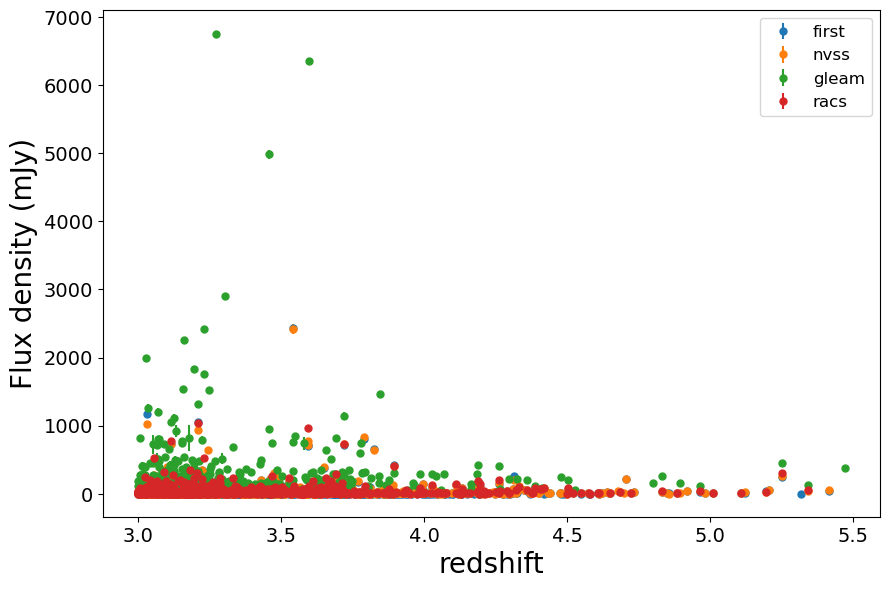

In [ ]:
ax1 = plt.figure(figsize=(9, 6))
ax1 = plt.subplot(111)

survey_name = flux_vs_z(axs=ax1,df_input=df_good ,survey = 'first', data_col = 'Fint_r1', error_col = 'Rms_r1')
survey_name = flux_vs_z(axs=ax1,df_input=df_good ,survey = 'nvss', data_col = 'S1.4_r2', error_col = 'e_S1.4_r2')
survey_name = flux_vs_z(axs=ax1,df_input=df_good ,survey = 'gleam', data_col = 'Fintwide_r3', error_col = 'e_Fintwide_r3')
survey_name = flux_vs_z(axs=ax1,df_input=df_good ,survey = 'racs', data_col = 'Ftot_r4', error_col = 'e_Ftot_r4')
ax1.set_xlabel(f'redshift', fontsize=20)
ax1.set_ylabel('Flux density (mJy)', fontsize=20)
# using log scale for y-axis
# ax1.set_ylim(0, 1000)
# ax1.set_yscale('log')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.legend(fontsize=12)
plt.tight_layout()
# plt.savefig(f"{survey_name}_SDSS_flux.pdf", format='pdf', dpi=200)
plt.show()

### Table: make the final tables for paper

In [75]:
from pathlib import Path
import pandas as pd
import os
os.chdir('/Users/yingkangzhang/wps_workspace/wps_cloud/hi_z')
ref_after = Path("/Users/yingkangzhang/wps_workspace/wps_cloud/hi_z/inspected_catalog2.csv")
table_after = pd.read_csv(ref_after,encoding='gbk')
table_after.columns

Index(['sdss_name', 'sdss_ra', 'sdss_dec', 'sdss_z', 'sdss_source_z',
       'sdss_zwarning', 'z_reliable_flag', 'FIRST', 'match_tier_first',
       'Fpeak_first', 'Fint_first', 'Rms_first', 'NVSS', 'match_tier_nvss',
       'S1.4_nvss', 'e_S1.4_nvss', 'GLEAM', 'match_tier_gleam', 'Fpwide_gleam',
       'e_Fpwide_gleam', 'Fintwide_gleam', 'e_Fintwide_gleam', 'RACS-DR1',
       'match_tier_racs', 'Fpk_racs', 'e_Fpk_racs', 'Ftot_racs', 'e_Ftot_racs',
       'match_tier_flag', 'match_tier_mark', 'sep_first', 'sep_nvss',
       'sep_racs', 'sep_gleam', 'resolve_gleam', 'sdss_name.1', 'Sample',
       'Note1', 'Note2', 'first_code', 'nvss_code', 'racs_code', 'gleam_code'],
      dtype='object')

In [81]:
# define columns for table1: classification table
columns_t1_mapping={'sdss_name':'sdss_name','sdss_ra':'sdss_ra','sdss_dec':'sdss_dec','Sample':'category','sdss_z':'sdss_z',
            'sdss_source_z':'sdss_source_z','sdss_zwarning':'sdss_zwarning','z_reliable_flag':'z_reliable_flag',
            'FIRST':'FIRST','NVSS':'NVSS','RACS-DR1':'RACS','GLEAM':'GLEAM','match_tier_mark':'match_tier_code',
            'sep_first':'SEP_FIRST','sep_nvss':'SEP_NVSS','sep_racs':'SEP_RACS','sep_gleam':'SEP_GLEAM',
            'first_code':'VI_code_FIRST','nvss_code':'VI_code_NVSS','racs_code':'VI_code_RACS','gleam_code':'VI_code_GLEAM',
            'Note1':'comment_1','Note2':'comment_2'}

df_t1 = table_after[columns_t1_mapping.keys()].rename(columns=columns_t1_mapping)
df_t1.replace([-32768,-2147483648], 'NA', inplace=True)
df_t1['match_tier_code'] = df_t1.apply(lambda row: f"{int(row['match_tier_code']):04d}" if pd.notna(row['match_tier_code']) else "0000", axis=1)
df_t1['sdss_ra'] = df_t1['sdss_ra'].round(8)
df_t1['sdss_dec'] = df_t1['sdss_dec'].round(8)
df_t1.to_csv('final_table1_category.csv', index=False)
# define columns for table2: parameter table
columns_t2=['sdss_name','sdss_ra','sdss_dec','Sample','sdss_z',
            'FIRST', 'Fpeak_first', 'Fint_first', 'Rms_first',
            'NVSS','S1.4_nvss','e_S1.4_nvss',
            'RACS-DR1','Fpk_racs','e_Fpk_racs','Ftot_racs','e_Ftot_racs',
            'GLEAM','Fpwide_gleam','e_Fpwide_gleam','Fintwide_gleam','e_Fintwide_gleam'
            ]

df_t2 = table_after[columns_t2]
df_t2.rename(columns={'Sample':'category'}, inplace=True)
df_t2['sdss_ra'] = df_t2['sdss_ra'].round(8)
df_t2['sdss_dec'] = df_t2['sdss_dec'].round(8)
df_t2.replace([-32768,-2147483648], 'NA', inplace=True)
df_t2.to_csv('final_table2_parameters.csv', index=False)


/var/folders/71/gshyfsc16lv27mjb4j1d21000000gn/T/ipykernel_23306/3912438776.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t2.rename(columns={'Sample':'category'}, inplace=True)
/var/folders/71/gshyfsc16lv27mjb4j1d21000000gn/T/ipykernel_23306/3912438776.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t2['sdss_ra'] = df_t2['sdss_ra'].round(8)
/var/folders/71/gshyfsc16lv27mjb4j1d21000000gn/T/ipykernel_23306/3912438776.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

### Test for the galaxy catalg

In [ ]:
import pandas as pd
from astropy.io import fits
import numpy as np
from astropy.table import Table

# tables to be concatenated
sdss_galaxy = "../catalogues/dr16_galaxy_all.fits"
dr16q_short = "tmp_sdss.fits"

with fits.open(sdss_galaxy) as hdul:
    data = hdul[1].data 
    table_g = Table(data)  
df_g = table_g.to_pandas()  
with fits.open(dr16q_short) as hdul:
    data = hdul[1].data  
    table_q = Table(data) 
df_q = table_q.to_pandas()  


In [ ]:
combined_df = pd.concat([df_q, df_g], ignore_index=True, sort=False)
combined_df

In [ ]:

combined_df_sorted = combined_df.sort_values(by='SDSS_NAME', ascending=True)
combined_df_sorted.reset_index(drop=True, inplace=True)

table_combined = Table.from_pandas(combined_df_sorted)
table_combined.write('tmp_sdss16_sorted.fits', format='fits', overwrite=True)

print(f"Saved combined table with {len(combined_df_sorted)} rows to 'combined_sdss_sorted.fits'")
print("First few rows after sorting:")
print(combined_df_sorted[['SDSS_NAME', 'RA', 'DEC', 'Z']].head())